In [ ]:
import numpy as np
import pandas as pd

from pymatgen.core import Composition

from matminer.datasets import load_dataset
from matminer.featurizers.composition import ElementProperty, Stoichiometry, ValenceOrbital
from matminer.featurizers.base import MultipleFeaturizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)

RANDOM_STATE = 42

## 1) Load datasets

In [ ]:
cls = load_dataset("matbench_expt_is_metal")  # columns: composition, is_metal
reg = load_dataset("matbench_expt_gap")       # columns: composition, gap expt

Fetching matbench_expt_is_metal.json.gz from https://ml.materialsproject.org/projects/matbench_expt_is_metal.json.gz to c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\datasets\matbench_expt_is_metal.json.gz


Fetching https://ml.materialsproject.org/projects/matbench_expt_is_metal.json.gz in MB: 0.034816MB [00:00, 17.20MB/s]                 

Fetching matbench_expt_gap.json.gz from https://ml.materialsproject.org/projects/matbench_expt_gap.json.gz to c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\datasets\matbench_expt_gap.json.gz



Fetching https://ml.materialsproject.org/projects/matbench_expt_gap.json.gz in MB: 0.038911999999999995MB [00:00,  9.29MB/s]   


In [5]:
reg.describe()

,gap expt
count,4604.000000
mean,0.975951
std,1.445034
min,0.000000
25%,0.000000
50%,0.000000
75%,1.812500
max,11.700000


## 2) Featurize once (composition-only)


In [ ]:

def featurize_compositions(formulas: pd.Series) -> pd.DataFrame:

    df = pd.DataFrame({"formula": formulas})
    df["composition"] = df["formula"].apply(Composition)  #converts chemical formula string into pymatgen Composition object

    # Magpie-style + stoichiometry + optional valence orbital fractions
    featurizer = MultipleFeaturizer(
        [
            Stoichiometry(),
            ElementProperty.from_preset("magpie"),
            ValenceOrbital(),  
        ]
    )

    df = featurizer.featurize_dataframe(df, col_id="composition", ignore_errors=True)
    feature_cols = [c for c in df.columns if c not in ("formula", "composition")]
    # convert feature columns to numeric; replace with NaN if conversion fails
    X = df[feature_cols].apply(pd.to_numeric, errors="coerce")
    return X


X_cls = featurize_compositions(cls["composition"])
y_cls = cls["is_metal"].astype(int).to_numpy()

X_reg_all = featurize_compositions(reg["composition"])
y_reg_all = reg["gap expt"].astype(float).to_numpy()

# We only apply regression for non-metallic materials, so we drop gap == 0
# For matbench_expt_gap, gaps are experimental semiconductors; still, we’ll enforce y>0.
nonmetal_mask = y_reg_all > 0
X_reg = X_reg_all.loc[nonmetal_mask].to_numpy()
y_reg = y_reg_all[nonmetal_mask]

c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)
c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\featurizers\composition\orbital.py:115: UserWarning: ValenceOrbital(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source 

MultipleFeaturizer:   0%|          | 0/4921 [00:00<?, ?it/s]

c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)
c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\featurizers\composition\orbital.py:115: UserWarning: ValenceOrbital(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source 

MultipleFeaturizer:   0%|          | 0/4604 [00:00<?, ?it/s]

In [14]:
X_reg

array([[4.        , 0.62164677, 0.5697613 , ..., 0.23243243, 0.35135135,
        0.26486486],
       [4.        , 0.62164677, 0.5697613 , ..., 0.16226415, 0.54716981,
        0.18490566],
       [3.        , 0.62360956, 0.55032121, ..., 0.25925926, 0.55555556,
        0.        ],
       ...,
       [2.        , 0.74535599, 0.69336127, ..., 0.5       , 0.125     ,
        0.        ],
       [2.        , 0.74535599, 0.69336127, ..., 0.22222222, 0.61111111,
        0.        ],
       [3.        , 0.66332496, 0.61446337, ..., 0.23684211, 0.13157895,
        0.36842105]], shape=(2154, 146))

## 3) Split data

In [ ]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_cls.to_numpy(),
    y_cls,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_cls,
)

Xr_train, Xr_test, yr_train, yr_test = train_test_split(
    X_reg,
    y_reg,
    test_size=0.2,
    random_state=RANDOM_STATE,
)

# preprocessing: impute + scale (for SVM)
preprocess = [
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
]

## 4) Stage 1 — SVC metal vs nonmetal

In [ ]:
svc_pipe = Pipeline(
    preprocess
    + [
        (
            "svc",
            SVC(kernel="rbf", class_weight="balanced"),
        )
    ]
)

svc_grid = {
    "svc__C": [0.5, 1, 2, 5, 10, 50, 100], #C — regularization strength
    "svc__gamma": ["scale", 0.01, 0.05, 0.1, 0.2], #gamma — kernel width (RBF)  
}

svc_search = GridSearchCV(
    svc_pipe,
    svc_grid,
    cv=5, #5 fold cross-validation
    scoring="balanced_accuracy",
    n_jobs=-1,
    verbose=1,
)
svc_search.fit(Xc_train, yc_train)
best_svc = svc_search.best_estimator_

yc_pred = best_svc.predict(Xc_test)
print("\n=== Stage 1: SVC metal vs nonmetal ===")
print("Best params:", svc_search.best_params_)
print("Accuracy:", accuracy_score(yc_test, yc_pred))
print("Balanced accuracy:", balanced_accuracy_score(yc_test, yc_pred))
print("Confusion matrix [rows=true, cols=pred]:\n", confusion_matrix(yc_test, yc_pred))



Fitting 5 folds for each of 35 candidates, totalling 175 fits

=== Stage 1: SVC metal vs nonmetal ===
Best params: {'svc__C': 10, 'svc__gamma': 'scale'}
Accuracy: 0.917766497461929
Balanced accuracy: 0.9177688267354899
Confusion matrix [rows=true, cols=pred]:
 [[453  41]
 [ 40 451]]


## 5) Stage 2 — SVR band gap for nonmetals

In [ ]:
def print_regression_report(y_true: np.ndarray, y_pred: np.ndarray, label: str) -> None:
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"\n[{label}]")
    print(f"  RMSE: {rmse:.3f} eV")
    print(f"  MAE : {mae:.3f} eV")
    print(f"  R^2 : {r2:.3f}")


svr_pipe = Pipeline(
    preprocess
    + [
        (
            "svr",
            SVR(kernel="rbf"),
        )
    ]
)

svr_grid = {
    "svr__C": [1, 2, 5, 10, 20, 50, 100],
    "svr__gamma": ["scale", 0.01, 0.05, 0.1, 0.2],
    "svr__epsilon": [0.01, 0.05, 0.1, 0.2],
}

svr_search = GridSearchCV(
    svr_pipe,
    svr_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1,
)
svr_search.fit(Xr_train, yr_train)
best_svr = svr_search.best_estimator_

yr_pred = best_svr.predict(Xr_test)

print("\n=== Stage 2: SVR band gap (nonmetals) ===")
print("Best params:", svr_search.best_params_)
print_regression_report(yr_test, yr_pred, "Test set metrics")

Fitting 5 folds for each of 140 candidates, totalling 700 fits

=== Stage 2: SVR band gap (nonmetals) ===
Best params: {'svr__C': 10, 'svr__epsilon': 0.1, 'svr__gamma': 'scale'}

[Test set metrics]
  RMSE: 0.620 eV
  MAE : 0.398 eV
  R^2 : 0.815


## 6) Prediction from raw chemical formula

In [ ]:
# -----------------------------
#    (classify first; only regression if predicted nonmetal)
# -----------------------------
def predict_gap_from_formula(formula: str) -> dict:
    X_one = featurize_compositions(pd.Series([formula])).to_numpy()
    is_metal_pred = int(best_svc.predict(X_one)[0])
    out = {"formula": formula, "pred_is_metal": is_metal_pred}
    if is_metal_pred == 1:
        out["pred_gap_eV"] = 0.0
    else:
        out["pred_gap_eV"] = float(best_svr.predict(X_one)[0])
    return out

demo = ["SiO2", "GaAs", "Fe", "BaTiO3"]
print("\n=== Demo predictions ===")
for f in demo:
    print(predict_gap_from_formula(f))


=== Demo predictions ===


c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)
c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\featurizers\composition\orbital.py:115: UserWarning: ValenceOrbital(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source 

MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

{'formula': 'SiO2', 'pred_is_metal': 1, 'pred_gap_eV': 0.0}


c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)
c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\featurizers\composition\orbital.py:115: UserWarning: ValenceOrbital(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source 

MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

{'formula': 'GaAs', 'pred_is_metal': 0, 'pred_gap_eV': 0.8953203929253668}


c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)
c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\featurizers\composition\orbital.py:115: UserWarning: ValenceOrbital(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source 

MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

{'formula': 'Fe', 'pred_is_metal': 1, 'pred_gap_eV': 0.0}


c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\utils\data.py:326: UserWarning: MagpieData(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source will be replaced by the average of that value
                    over the available elements.
                    This avoids NaNs after featurization that are often replaced by
                    dataset-dependent averages.
  warnings.warn(f"{self.__class__.__name__}(impute_nan=False):\n" + IMPUTE_NAN_WARNING)
c:\Users\subin\Projects\materials_project\mp-env\Lib\site-packages\matminer\featurizers\composition\orbital.py:115: UserWarning: ValenceOrbital(impute_nan=False):
In a future release, impute_nan will be set to True by default.
                    This means that features that are missing or are NaNs for elements
                    from the data source 

MultipleFeaturizer:   0%|          | 0/1 [00:00<?, ?it/s]

{'formula': 'BaTiO3', 'pred_is_metal': 0, 'pred_gap_eV': 3.9322182272148787}


## SVR model performance

In [26]:
from sklearn.model_selection import KFold, cross_val_predict

def regression_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return rmse, mae, r2

# ---- Test set evaluation ----
y_pred_test = best_svr.predict(Xr_test)
rmse, mae, r2 = regression_metrics(yr_test, y_pred_test)

print("=== SVR Regression Performance (Test Set) ===")
print(f"RMSE: {rmse:.3f} eV")
print(f"MAE : {mae:.3f} eV")
print(f"R^2 : {r2:.3f}")

# ---- Error distribution summary ----
residuals = y_pred_test - yr_test
abs_err = np.abs(residuals)

print("\n=== Error summary (Test Set) ===")
for q in [50, 75, 90, 95, 99]:
    print(f"{q:>2}th percentile |abs error|: {np.percentile(abs_err, q):.3f} eV")
print(f"Max |error|: {abs_err.max():.3f} eV")

# ---- 5-fold CV prediction on TRAIN set ----
# This gives you a robust estimate without touching the held-out test set
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(best_svr, Xr_train, yr_train, cv=cv, n_jobs=-1)

rmse_cv, mae_cv, r2_cv = regression_metrics(yr_train, y_pred_cv)
print("\n=== 5-fold CV on Training Set (cross_val_predict) ===")
print(f"RMSE: {rmse_cv:.3f} eV")
print(f"MAE : {mae_cv:.3f} eV")
print(f"R^2 : {r2_cv:.3f}")


=== SVR Regression Performance (Test Set) ===
RMSE: 0.620 eV
MAE : 0.398 eV
R^2 : 0.815

=== Error summary (Test Set) ===
50th percentile |abs error|: 0.218 eV
75th percentile |abs error|: 0.509 eV
90th percentile |abs error|: 0.948 eV
95th percentile |abs error|: 1.404 eV
99th percentile |abs error|: 2.155 eV
Max |error|: 4.246 eV

=== 5-fold CV on Training Set (cross_val_predict) ===
RMSE: 0.687 eV
MAE : 0.435 eV
R^2 : 0.782


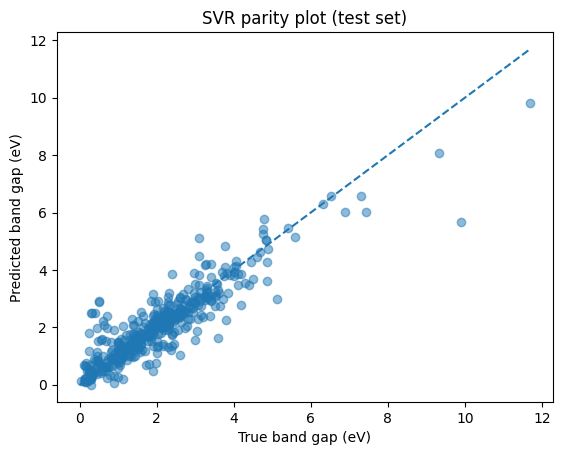

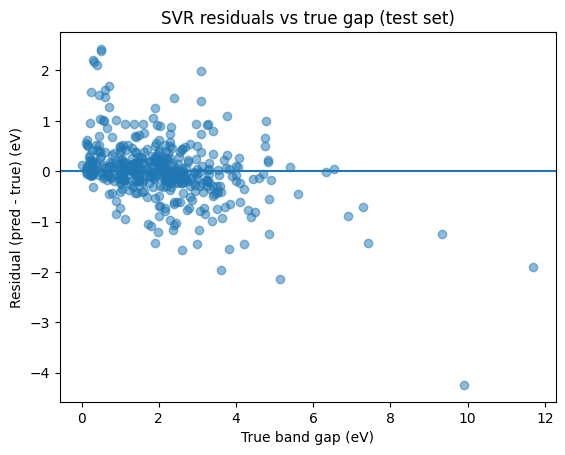

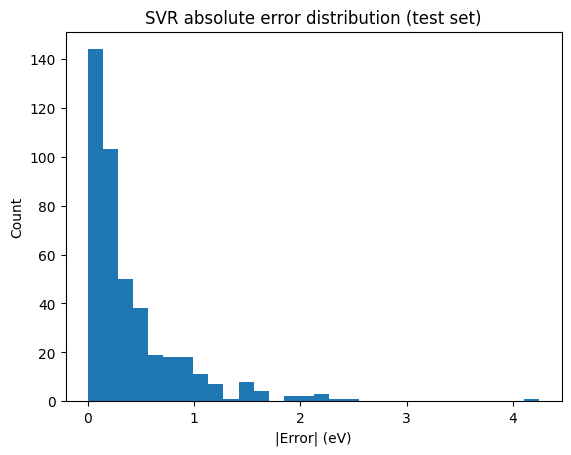

In [37]:
import matplotlib.pyplot as plt

# Predict on test set
y_pred_test = best_svr.predict(Xr_test)
residuals = y_pred_test - yr_test
abs_err = np.abs(residuals)

# ---- Plot 1: Parity plot (predicted vs true) ----
plt.figure()
plt.scatter(yr_test, y_pred_test, alpha=0.5)
minv = min(yr_test.min(), y_pred_test.min())
maxv = max(yr_test.max(), y_pred_test.max())
plt.plot([minv, maxv], [minv, maxv], '--')  # y=x line
plt.xlabel("True band gap (eV)")
plt.ylabel("Predicted band gap (eV)")
plt.title("SVR parity plot (test set)")
plt.show()

# ---- Plot 2: Residuals vs true ----
plt.figure()
plt.scatter(yr_test, residuals, alpha=0.5)
plt.axhline(0)
plt.xlabel("True band gap (eV)")
plt.ylabel("Residual (pred - true) (eV)")
plt.title("SVR residuals vs true gap (test set)")
plt.show()

# ---- Plot 3: Absolute error histogram ----
plt.figure()
plt.hist(abs_err, bins=30)
plt.xlabel("|Error| (eV)")
plt.ylabel("Count")
plt.title("SVR absolute error distribution (test set)")
plt.show()


## SVC model performance

In [28]:
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

# Predictions
y_pred = best_svc.predict(Xc_test)

print("=== SVC Performance (Test Set) ===")
print(f"Accuracy          : {accuracy_score(yc_test, y_pred):.3f}")
print(f"Balanced accuracy : {balanced_accuracy_score(yc_test, y_pred):.3f}")
print(f"Precision (metal=1): {precision_score(yc_test, y_pred, pos_label=1):.3f}")
print(f"Recall (metal=1)   : {recall_score(yc_test, y_pred, pos_label=1):.3f}")
print(f"F1 (metal=1)       : {f1_score(yc_test, y_pred, pos_label=1):.3f}")

cm = confusion_matrix(yc_test, y_pred)
print("\nConfusion matrix [rows=true, cols=pred]:")
print(cm)

print("\nClassification report:")
print(classification_report(yc_test, y_pred, target_names=["nonmetal(0)", "metal(1)"]))

# ROC-AUC (needs decision scores or probabilities)
if hasattr(best_svc.named_steps["svc"], "decision_function"):
    scores = best_svc.decision_function(Xc_test)
    print(f"ROC-AUC (decision_function): {roc_auc_score(yc_test, scores):.3f}")
elif hasattr(best_svc.named_steps["svc"], "predict_proba"):
    probs = best_svc.predict_proba(Xc_test)[:, 1]
    print(f"ROC-AUC (predict_proba): {roc_auc_score(yc_test, probs):.3f}")
else:
    print("ROC-AUC skipped: model has no decision_function or predict_proba.")

=== SVC Performance (Test Set) ===
Accuracy          : 0.918
Balanced accuracy : 0.918
Precision (metal=1): 0.917
Recall (metal=1)   : 0.919
F1 (metal=1)       : 0.918

Confusion matrix [rows=true, cols=pred]:
[[453  41]
 [ 40 451]]

Classification report:
              precision    recall  f1-score   support

 nonmetal(0)       0.92      0.92      0.92       494
    metal(1)       0.92      0.92      0.92       491

    accuracy                           0.92       985
   macro avg       0.92      0.92      0.92       985
weighted avg       0.92      0.92      0.92       985

ROC-AUC (decision_function): 0.967


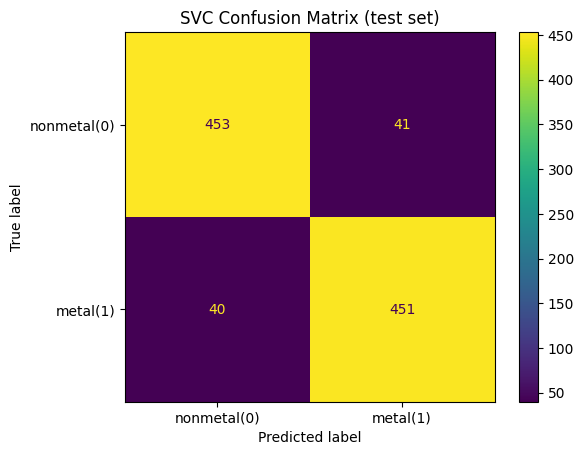

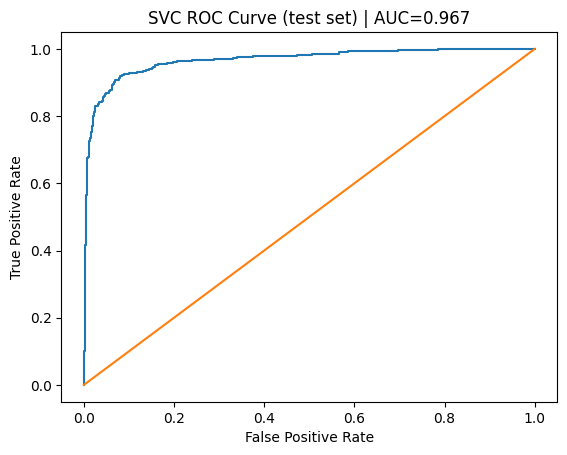

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, roc_auc_score

# ---- Confusion matrix plot ----
y_pred = best_svc.predict(Xc_test)
disp = ConfusionMatrixDisplay.from_predictions(
    yc_test, y_pred,
    display_labels=["nonmetal(0)", "metal(1)"]
)
plt.title("SVC Confusion Matrix (test set)")
plt.show()

# ---- ROC curve plot ----
if hasattr(best_svc, "decision_function"):
    scores = best_svc.decision_function(Xc_test)
elif hasattr(best_svc, "predict_proba"):
    scores = best_svc.predict_proba(Xc_test)[:, 1]
else:
    scores = None

if scores is not None:
    fpr, tpr, _ = roc_curve(yc_test, scores)
    auc = roc_auc_score(yc_test, scores)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1])  # chance line
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"SVC ROC Curve (test set) | AUC={auc:.3f}")
    plt.show()
else:
    print("ROC curve skipped: model has no decision_function or predict_proba.")


In [40]:
import joblib

joblib.dump(best_svc, "results/best_svc.joblib")
joblib.dump(best_svr, "results/best_svr.joblib")

['results/best_svr.joblib']